## Imports

In [1]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import numpy as np
import math
import yfinance as yf
import tradingview_ta as tv
from tradingview_ta import TA_Handler, Interval, Exchange
import warnings
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib widget
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import os
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import json
import warnings
warnings.filterwarnings('ignore')
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')

#Tokenizing function libraries to import including the tokenizer and lemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from string import punctuation
import re

from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Input Stock

In [2]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
period = input('enter period of data eg 1y or 2y:')
interval = input('enter candle interval eg 1d, 1wk, 1mo, 1h')
stock = yf.Ticker(value)
print(stock.info)
df_stock = stock.history(period=period, interval=interval)
df_stock.index.duplicated().sum()
df_stock = df_stock.loc[~df_stock.index.duplicated(keep='first')]
df_stock.dropna(inplace=True)

Enter Stock Symbol: spy
enter period of data eg 1y or 2y: 1y
enter candle interval eg 1d, 1wk, 1mo, 1h 1d


{'exchange': 'PCX', 'shortName': 'SPDR S&P 500', 'longName': 'SPDR S&P 500 ETF Trust', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EDT', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-14400000', 'quoteType': 'ETF', 'symbol': 'SPY', 'messageBoardId': 'finmb_6160262', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 727660800, 'annualReportExpenseRatio': None, 'totalAssets': 371019022336, 'bookValue': None, 'fundFamily': 'SPDR State Street Global Advisors', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.013300001, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 'threeYear

## Create Bollinger Bands and Keltner Channel


In [3]:
# parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages and future indicator additions
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [4]:
# calculate Bollinger Bands which are the measure of the standard deviation.  These bands are set at the 2 times standard deviation
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std
df_stock['bol_percent_b'] = ((df_stock['Close'] - df_stock['lower_BB'])/(df_stock['upper_BB'] - df_stock['lower_BB']))*100

In [5]:
# calculate Keltner Channel which is a measure of the average true range.  In this case the channels are set to twice the average true range
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

## Create Candlestick Chart

In [6]:
# Creating dataframe to graph in candle stick mode
ohcl = df_stock[['Open', 'High', 'Close', 'Low', 'Volume']]
display(ohcl.head())
display(ohcl.tail())


,Open,High,Close,Low,Volume
Date,,,,,
2021-05-21,411.455462,412.768204,409.550537,409.066911,76578700
2021-05-24,411.919338,414.860643,413.725586,411.662706,51376700
2021-05-25,414.870498,415.245567,412.807648,412.195705,57451400
2021-05-26,413.429508,414.159887,413.626923,412.333940,43088600
2021-05-27,414.712600,415.255444,413.844025,413.547903,56707700


,Open,High,Close,Low,Volume
Date,,,,,
2022-05-16,399.980011,403.970001,400.089996,397.600006,78622400
2022-05-17,406.529999,408.570007,408.320007,402.579987,83029700
2022-05-18,403.500000,403.799988,391.859985,390.549988,117674500
2022-05-19,388.619995,394.140015,389.459991,387.109985,98510700
2022-05-20,393.250000,397.029999,389.630005,380.540009,131209600


In [7]:
#Calculating true range and adding to dataframe
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()

In [8]:
#Stacked Moving averages, exponentially weighted.  Focusing on Fibonacci numbers here with 8, 21, 34, 55 and 89 day moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [9]:
#Adding Moving Average Variable
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg

In [10]:
#ADX Calculations
# Above 20 ADX means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending

In [11]:
#It uses the average directional index to determine the strength of the trend
#If ADX > 20 and the plus_di is above the minus_di the trend is positive
#If ADX > 20 and the plus_di is below the minus_di the trend is negative
#If ADX < 20 the trend is sideways

df_stock['ADX_trend'] = 20

def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        print('positive trend')
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        print('negative trend')
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        print('neutral or sideways trend')

In [12]:
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Moving average,upper_BB,lower_BB,bol_percent_b,tr0,tr1,tr2,tr,upper_KC,lower_KC,m_avg_08,m_avg_21,m_avg_34,m_avg_55,m_avg_89,atr,plus_di,minus_di,adx,ADX_trend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-21,411.455462,412.768204,409.066911,409.550537,76578700,0.0,0,409.550537,NaN,NaN,NaN,3.701293,NaN,NaN,3.701293,416.953123,402.147951,409.550537,409.550537,409.550537,409.550537,409.550537,3.701293,NaN,NaN,NaN,20
2021-05-24,411.919338,414.860643,411.662706,413.725586,51376700,0.0,0,411.742438,NaN,NaN,NaN,3.197937,5.310106,2.112168,5.310106,420.830447,402.654429,411.899002,411.737467,411.699459,411.676017,411.661517,4.563157,45.855072,0.000000,NaN,20
2021-05-25,414.870498,415.245567,412.195705,412.807648,57451400,0.0,0,412.133576,NaN,NaN,NaN,3.049862,1.519981,1.529880,3.049862,420.129191,404.137962,412.280351,412.128681,412.090791,412.067025,412.052178,3.985073,30.289554,0.000000,100.000000,20
2021-05-26,413.429508,414.159887,412.333940,413.626923,43088600,0.0,0,412.564682,NaN,NaN,NaN,1.825947,1.352239,0.473708,1.825947,419.314554,405.814810,412.752298,412.558364,412.509354,412.478524,412.459232,3.324536,23.297964,0.000000,100.000000,20
2021-05-27,414.712600,415.255444,413.547903,413.844025,56707700,0.0,0,412.874144,NaN,NaN,NaN,1.707541,1.628521,0.079019,1.707541,418.824281,406.924008,413.091431,412.866686,412.808587,412.771840,412.748777,2.902664,29.763334,0.000000,100.000000,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,399.980011,403.970001,397.600006,400.089996,78622400,0.0,0,413.566989,445.777755,381.356222,29.079989,6.369995,2.250000,4.119995,6.369995,434.735851,392.398126,402.491573,414.295951,421.436016,428.101134,433.961600,10.840369,16.244081,27.220657,24.293852,20
2022-05-17,406.529999,408.570007,402.579987,408.320007,83029700,0.0,0,413.067276,442.425470,383.709082,41.914917,5.990021,8.480011,2.489990,8.480011,433.853517,392.281035,403.786781,413.752683,420.686529,427.394586,433.389710,10.525654,18.656419,26.032080,24.317793,20
2022-05-18,403.500000,403.799988,390.549988,391.859985,117674500,0.0,0,411.047534,438.362488,383.732581,14.877208,13.250000,4.520020,17.770020,17.770020,433.175029,388.920039,401.136382,411.762438,419.039298,426.125355,432.463539,11.491570,15.867677,29.618362,23.829738,20


## Chart 

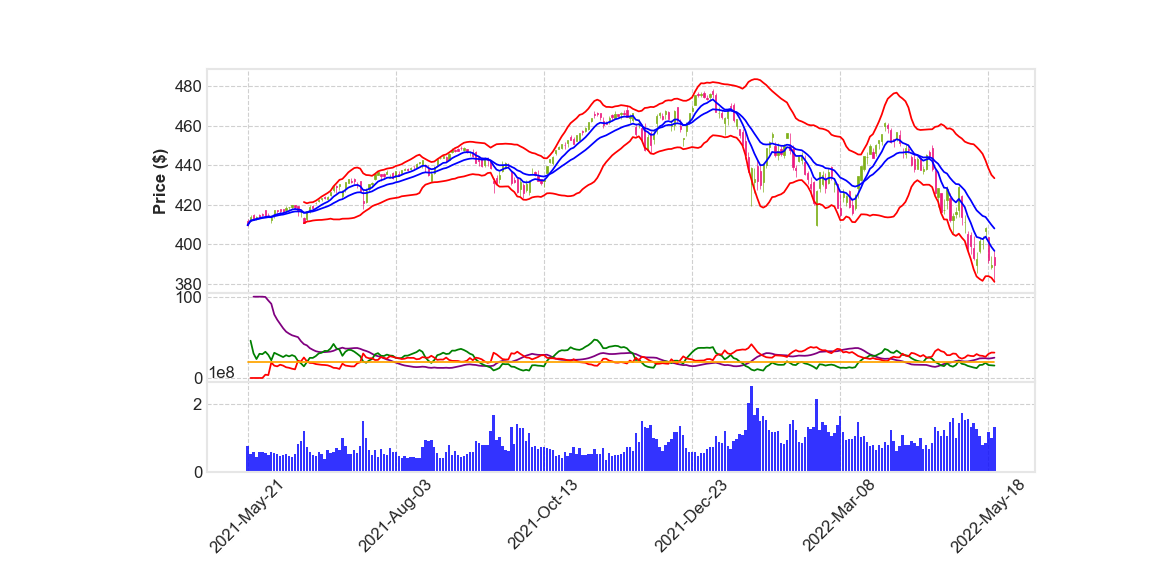

In [13]:
# Adding all the plots including ADX, 
apds = [mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock['m_avg_08'], color = 'blue'),
        mpf.make_addplot(df_stock['m_avg_21'], color = 'blue'),
        mpf.make_addplot(df_stock[['adx']], panel=1, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=1, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=1, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock[['ADX_trend']], panel=1, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock['Volume'], panel=2, type='bar', color= 'blue', alpha = 0.8, secondary_y=False)]


fig, axes = mpf.plot(df_stock,
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              ylabel='Price ($)',
              addplot=apds,
              returnfig=True)

#If plus_di (green) > minus_di(orange)

## Fibonnacci Level Chart

In [14]:
start_date = input("Enter start date:") 
end_date = input("Enter end date:") 
interval_1 = input("enter candle interval") 
df = stock.history(interval=interval_1,start=start_date,end=end_date)

Enter start date: 2022-01-03
Enter end date: 2022-04-03
enter candle interval 1h


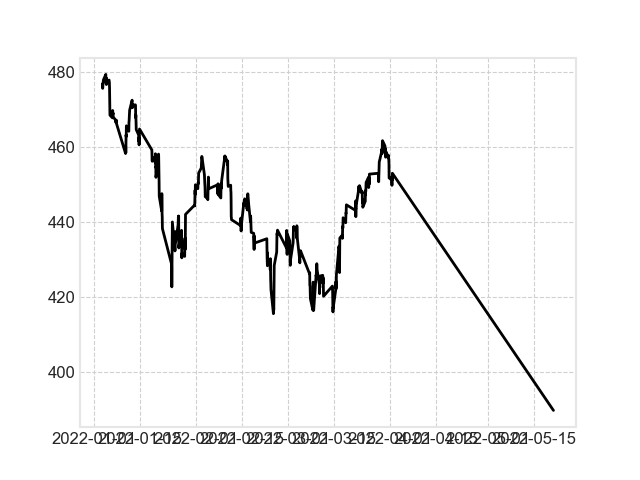

In [15]:
#Graph for the Fibonacci Levels
fig, ax = plt.subplots()
ax.plot(df.Close, color='black')

## Adding Fib Levels

In [16]:
# Define minimum and maximum price points
price_min = df.Close.min()
price_max = df.Close.max()

In [17]:
# Fibonacci Levels using the high and the low of the time period in question
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff
level5 = price_max - 0.786 * diff

No handles with labels found to put in legend.


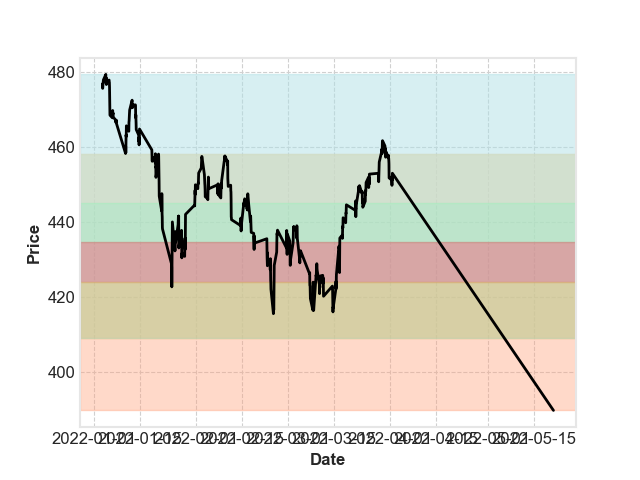

In [18]:
#This adds the Fibonacci Levels to the graph above:
#Level 1 at 23.6%
#Level 2 at 38.2%
#Level 3 at 50%
#Level 4 at 61.8%
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(level4, level3, alpha=0.5, color='red')
ax.axhspan(level5, level4, alpha=0.5, color='orange')
ax.axhspan(price_max, level5, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

## Tradingview Rec

In [19]:
symbol_tv = TA_Handler(
    symbol="TSLA",
    screener="america",
    exchange="NASDAQ",
    interval=Interval.INTERVAL_1_HOUR,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(symbol_tv.get_analysis().summary)

{'RECOMMENDATION': 'SELL', 'BUY': 2, 'SELL': 14, 'NEUTRAL': 10}


# Rules for Entering a Trade. 
## Points must add up to at least 9/12
1. Identify strong trend and direction using ADX (+3pt)
2. Price is at the low/high of Bollinger Bands and Keltner Channel (+3pt)
3. Price is near a fibonnacci level (+3pt)
4. Volume is near the highs of the day (+2pt)
5. Use tradingview reccomendation before making final decision. (+1pt)

## News API


In [20]:
value = input("Enter Stock Symbol:")

Enter Stock Symbol: spy


In [37]:
# Read your api key environment variable
from newsapi.newsapi_client import NewsApiClient
load_dotenv()
api_key = os.getenv('NEWSAPI_KEY')

In [38]:
api_key

'da1e9a6806334ef58648fbb684ba57df'

In [39]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [40]:
# Fetch the Stock news articles
stock_headlines = newsapi.get_everything(q=value,
                                        language="en",
                                        page_size=100,
                                        sort_by='relevancy')
#save json
with open('stock.json', 'w') as json_file:
   json.dump(stock_headlines, json_file)

In [41]:
# Create the Stock sentiment scores DataFrame
tc = pd.read_json ('stock.json')
#parse the json and load into a dataframe
df_stock = json_normalize(stock_headlines['articles'])
#drop all columns except for description
df_stock = df_stock.drop(['author', 'title', 'url','urlToImage','publishedAt','content','source.id','source.name'], axis=1)
#instantiate vader sentiment 
sentiment_title = df_stock.apply(lambda x : analyzer.polarity_scores(x['description']), axis=1)
#add a column for each sentimement metric
df_stock['Comp'] =sentiment_title.apply(lambda x : x.get('compound') )
df_stock['Pos'] =sentiment_title.apply(lambda x : x.get('pos') )
df_stock['Neu'] =sentiment_title.apply(lambda x : x.get('neu') )
df_stock['Neg'] =sentiment_title.apply(lambda x : x.get('neg') )
display(df_stock)

df_sentiment = df_stock['Comp'].sum()

display(df_sentiment)


,description,Comp,Pos,Neu,Neg
0,This week’s episode of the Paramount Plus Halo...,0.3400,0.085,0.915,0.000
1,Researchers have struggled to quantify in real...,0.1027,0.111,0.794,0.095
2,Law enforcement agencies are finding new and f...,-0.6705,0.050,0.792,0.158
3,The Spanish government sacked the country's sp...,0.0000,0.000,1.000,0.000
4,"""Squid Game"" star Lee Jung-jae flexes his film...",0.1027,0.065,0.935,0.000
...,...,...,...,...,...
95,Netflix teases the release of its new Russo Br...,-0.2960,0.000,0.950,0.050
96,We can think of one thing the S stands for in ...,-0.7351,0.000,0.863,0.137
97,If a network snoop probes like a Kremlin agent...,-0.1531,0.117,0.751,0.131
98,North Korea's admission that it is battling an...,-0.8519,0.000,0.731,0.269


-6.8114

In [42]:
df_stock.to_csv(r'Headlines.csv', index = False)

In [43]:
# Describe the stock Sentiment
df_stock.describe()

,Comp,Pos,Neu,Neg
count,100.000000,100.000000,100.000000,100.000000
mean,-0.068114,0.076330,0.833450,0.090250
std,0.513887,0.078106,0.100251,0.092666
min,-0.931300,0.000000,0.625000,0.000000
25%,-0.504075,0.000000,0.762250,0.000000
50%,0.000000,0.063500,0.823000,0.069500
75%,0.345300,0.128500,0.907250,0.157250
max,0.840200,0.325000,1.000000,0.368000


In [44]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [45]:
# Complete the tokenizer function which removes the stopwords and the punctuation and keeps the relevant words
def tokenizer(text):
    """Tokenizes text."""
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a list of the words
    tokens = word_tokenize(re_clean)
    # Convert the words to lowercase
    tokens = [t.lower() for t in tokens]
    # Remove the punctuation
    words = [t.translate(str.maketrans('','',string.punctuation)) for t in tokens]
    # Remove the stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # Lemmatize Words into root words
    tokens = ', '.join([lemmatizer.lemmatize(word) for word in words])
    return tokens

In [46]:
# Create a new tokens column for the stock
df_stock['tokens'] = df_stock.apply(lambda x : tokenizer(x['description']), axis=1)
df_stock

,description,Comp,Pos,Neu,Neg,tokens
0,This week’s episode of the Paramount Plus Halo...,0.3400,0.085,0.915,0.000,"week, episode, paramount, plus, halo, series, ..."
1,Researchers have struggled to quantify in real...,0.1027,0.111,0.794,0.095,"researcher, struggled, quantify, real, time, m..."
2,Law enforcement agencies are finding new and f...,-0.6705,0.050,0.792,0.158,"law, enforcement, agency, finding, new, andfla..."
3,The Spanish government sacked the country's sp...,0.0000,0.000,1.000,0.000,"spanish, government, sacked, country, spy, chi..."
4,"""Squid Game"" star Lee Jung-jae flexes his film...",0.1027,0.065,0.935,0.000,"squid, game, star, lee, jungjae, flex, filmmak..."
...,...,...,...,...,...,...
95,Netflix teases the release of its new Russo Br...,-0.2960,0.000,0.950,0.050,"netflix, tease, release, new, russo, brother, ..."
96,We can think of one thing the S stands for in ...,-0.7351,0.000,0.863,0.137,"think, one, thing, stand, unfortunate, casesmi..."
97,If a network snoop probes like a Kremlin agent...,-0.1531,0.117,0.751,0.131,"network, snoop, probe, like, kremlin, agent, e..."
98,North Korea's admission that it is battling an...,-0.8519,0.000,0.731,0.269,"north, korea, admission, battling, explosive, ..."


In [47]:
#libraries needed for counting the frequencies of words and phrases germane to the chosen topic
from collections import Counter
from nltk import ngrams
import nltk, re, string, collections
from collections import Counter
from nltk import ngrams
from nltk.collocations import *
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
#import janitor as jn
#import ConfigParser

In [48]:
# Generate the stock N-grams where N=2
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
#determine counts in the token column
sparse_matrix = word_vectorizer.fit_transform(df_stock['tokens'])
#sum counts
frequencies = sum(sparse_matrix).toarray()[0]
#create dataframe with ngram and count
df_stock_freq_2 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
df_stock_freq_2 = df_stock_freq_2.sort_values(by='frequency', ascending=False)
df_stock_freq_2.head(10)

,frequency
bear market,4
stock market,4
market territory,4
spy chief,4
united state,4
prime minister,4
spy thriller,3
market spy,3
sp spy,3
said wednesday,3


In [52]:
#Wordcloud libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [53]:
#join all text in tokens column into 1 string
corpus_stock = df_stock['tokens'].str.cat(sep=', ')

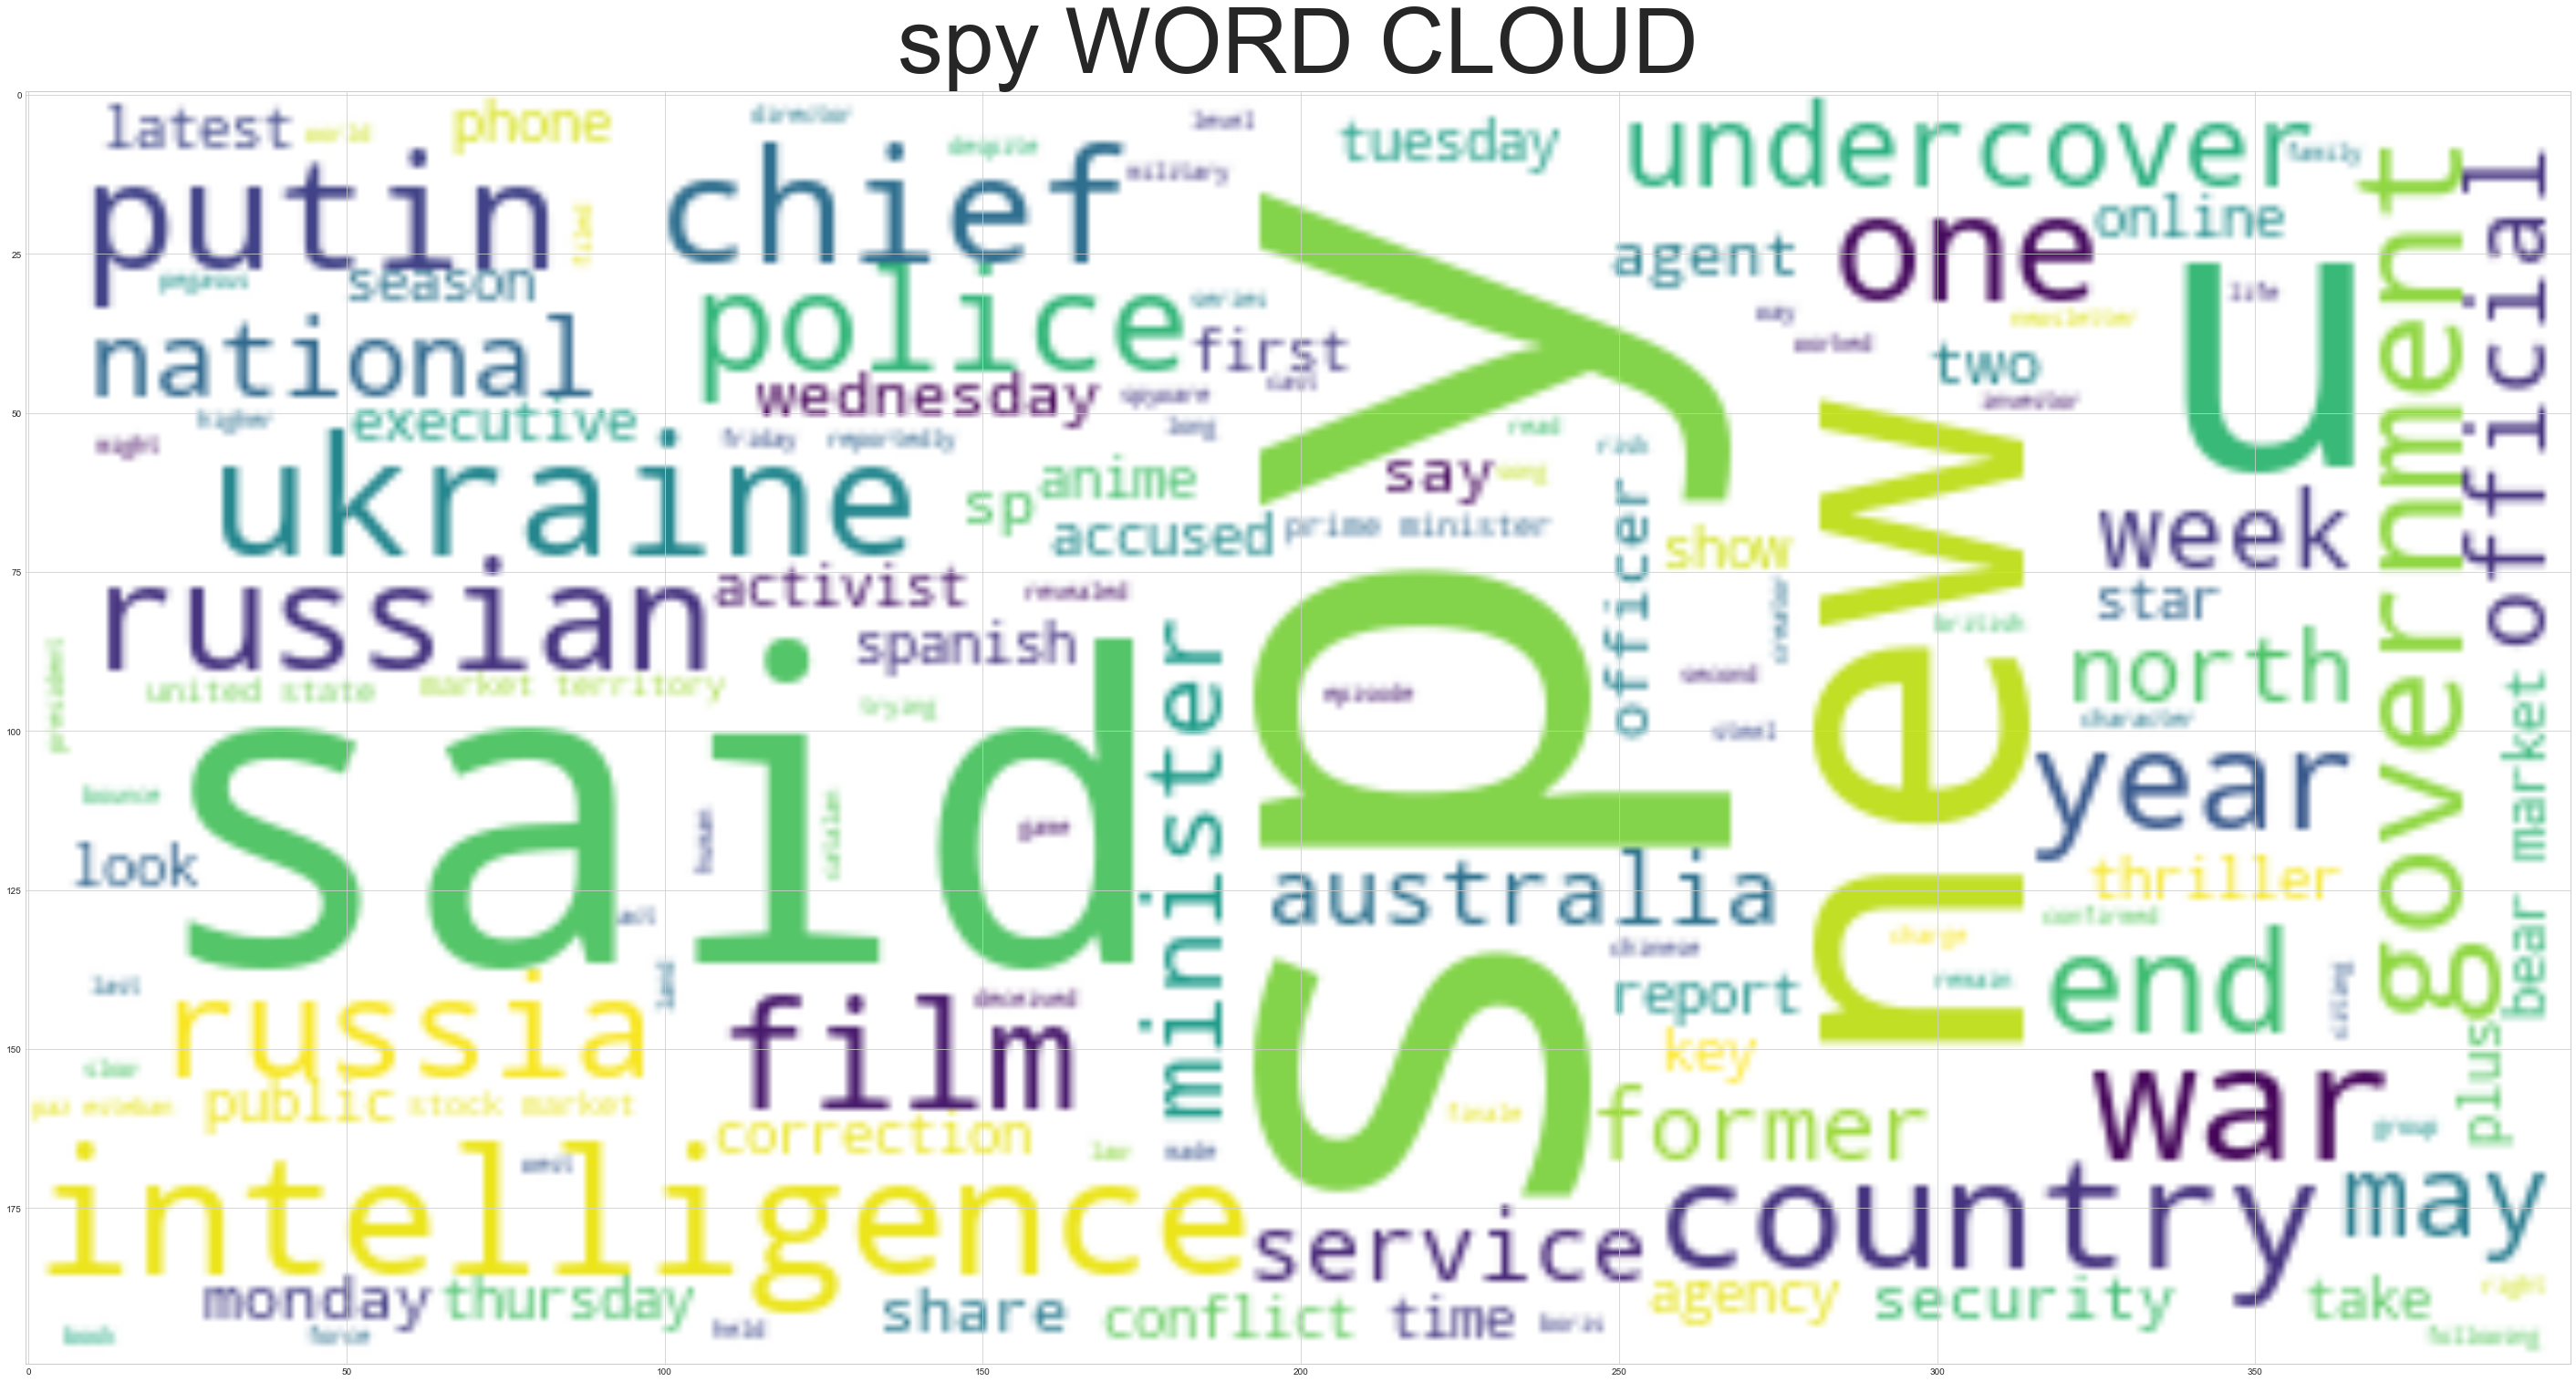

In [67]:
# Generate the stock word cloud
#create word cloud
wc = WordCloud(background_color="white", max_words=200)
wc.generate(corpus_stock)
f = plt.figure(figsize=(110,110))
f.add_subplot(1,2, 2)
plt.imshow(wc, interpolation='bilinear')
plt.title(f"{value} WORD CLOUD",fontsize=100)
plt.show()


#df_stock.to_csv(r'Headlines.csv', index = False)

In [66]:
fig.savefig("Wordcloud.png", bbox_inches='tight', dpi=150)


## SKLearn


In [46]:
# Import sklearn required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

In [47]:
df_stock["pct_change"] = df_stock['Close'].pct_change()*100

In [48]:
# Set x variable list of features
x_var_list = ['Open', 'High', 'Low', 'Close', 'Moving average', 'upper_BB', 'lower_BB', 'm_avg_08', 'pct_change', 'upper_KC', 'lower_KC']

# Filter by x-variable list
df_stock[x_var_list]

,Open,High,Low,Close,Moving average,upper_BB,lower_BB,m_avg_08,pct_change,upper_KC,lower_KC
Date,,,,,,,,,,,
2021-05-21,411.455462,412.768204,409.066911,409.550537,409.550537,NaN,NaN,409.550537,NaN,416.953123,402.147951
2021-05-24,411.919338,414.860643,411.662706,413.725586,411.742438,NaN,NaN,411.899002,1.019422,420.830447,402.654429
2021-05-25,414.870498,415.245567,412.195705,412.807648,412.133576,NaN,NaN,412.280351,-0.221871,420.129191,404.137962
2021-05-26,413.429478,414.159857,412.333910,413.626892,412.564674,NaN,NaN,412.752288,0.198457,419.314545,405.814802
2021-05-27,414.712600,415.255444,413.547903,413.844025,412.874138,NaN,NaN,413.091423,0.052495,418.824274,406.924002
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,399.980011,403.970001,397.600006,400.089996,413.566989,445.777755,381.356222,402.491573,-0.405756,434.735851,392.398126
2022-05-17,406.529999,408.570007,402.579987,408.320007,413.067276,442.425470,383.709082,403.786781,2.057040,433.853517,392.281035
2022-05-18,403.500000,403.799988,390.549988,391.859985,411.047534,438.362488,383.732581,401.136382,-4.031157,433.175029,388.920039


In [49]:
# Drop NAs
df_stock = df_stock.dropna(subset=x_var_list)
df_stock = df_stock.dropna(subset=["pct_change"])

# Replace positive/negative infinity values
df_stock = df_stock.replace([np.inf, -np.inf], np.nan)



In [50]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
df_stock["Positive Return"] = np.where(df_stock["pct_change"] > 0, 1.0, 0.0)

# Display sample data
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Moving average,upper_BB,lower_BB,bol_percent_b,tr0,tr1,tr2,tr,upper_KC,lower_KC,m_avg_08,m_avg_21,m_avg_34,m_avg_55,m_avg_89,atr,plus_di,minus_di,adx,ADX_trend,pct_change,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-18,413.019410,413.752179,410.652751,410.870605,118676300,1.376,0,415.953577,421.317566,410.589588,2.619482,3.099427,2.737018,5.836445,5.836445,422.330600,409.576554,415.867502,415.937894,415.772495,415.631333,415.530240,3.323089,14.312850,25.220624,41.643251,20,-1.349037,0.0
2021-06-21,412.732250,416.950685,411.870746,416.752625,72822000,0.000,0,416.040275,420.684467,411.396082,57.669251,5.079939,6.080079,1.000140,6.080079,423.025181,409.055369,416.065205,416.023533,415.851451,415.706316,415.602446,3.709845,19.604114,20.503409,40.143282,20,1.431599,1.0
2021-06-22,416.742729,419.861980,415.980224,418.980652,57700300,0.000,0,416.355134,421.120320,411.589949,77.548953,3.881756,3.109356,0.772400,3.881756,423.420736,409.289533,416.715665,416.330011,416.097760,415.918661,415.794904,3.733795,24.773257,18.527799,36.720808,20,0.534616,1.0
2021-06-23,419.059885,419.911478,418.386529,418.475647,49445400,0.000,0,416.579544,421.225539,411.933548,70.405779,1.524949,0.930826,0.594123,1.524949,423.234186,409.924901,417.107983,416.549591,416.280979,416.079790,415.942499,3.427901,24.715328,18.388550,34.704053,20,-0.120532,0.0
2021-06-24,420.743291,421.396823,420.475907,420.951233,45110300,0.000,0,417.037343,421.958175,412.116510,89.768581,0.920916,2.921176,2.000260,2.921176,423.609796,410.464889,417.964095,416.994957,416.633804,416.378607,416.209500,3.358087,26.888225,17.132026,32.972715,20,0.591572,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,399.980011,403.970001,397.600006,400.089996,78622400,0.000,0,413.566989,445.777755,381.356222,29.079989,6.369995,2.250000,4.119995,6.369995,434.735851,392.398126,402.491573,414.295951,421.436016,428.101134,433.961600,10.840369,16.244081,27.220657,24.293852,20,-0.405756,0.0
2022-05-17,406.529999,408.570007,402.579987,408.320007,83029700,0.000,0,413.067276,442.425470,383.709082,41.914917,5.990021,8.480011,2.489990,8.480011,433.853517,392.281035,403.786781,413.752683,420.686529,427.394586,433.389710,10.525654,18.656419,26.032080,24.317793,20,2.057040,1.0
2022-05-18,403.500000,403.799988,390.549988,391.859985,117674500,0.000,0,411.047534,438.362488,383.732581,14.877208,13.250000,4.520020,17.770020,17.770020,433.175029,388.920039,401.136382,411.762438,419.039298,426.125355,432.463539,11.491570,15.867677,29.618362,23.829738,20,-4.031157,0.0


In [51]:
# Construct training start and end dates
training_start = df_stock.index.min().strftime(format= "%Y-%m-%d")
training_end = "2021-07-19"

# Construct testing start and end dates
testing_start =  "2022-04-18"
testing_end = df_stock.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2021-06-18
Training End: 2021-07-19
Testing Start: 2022-04-18
Testing End: 2022-05-20


In [52]:
# Construct the X_train and y_train datasets
X_train = df_stock[x_var_list][training_start:training_end]
y_train = df_stock["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

,Open,High,Low,Close,Moving average,upper_BB,lower_BB,m_avg_08,pct_change,upper_KC,lower_KC
Date,,,,,,,,,,,
2021-07-13,431.982517,433.566908,431.061601,431.338867,425.310492,437.533671,413.087313,429.230663,-0.340893,431.898143,418.722841
2021-07-14,433.131165,433.646110,430.665476,431.982483,425.961977,438.570696,413.353258,429.842235,0.149213,432.490959,419.432996
2021-07-15,430.566492,431.279467,428.496893,430.507080,426.404717,438.818933,413.990502,429.989989,-0.341542,432.975003,419.834432
2021-07-16,431.754777,431.804277,426.714456,427.130341,426.475247,438.297282,414.653213,429.354476,-0.784363,433.381829,419.568665
2021-07-19,422.030604,427.199661,417.851788,420.822510,425.926881,435.886454,415.967308,427.458402,-1.476793,433.929421,417.924342


Date
2021-07-13    0.0
2021-07-14    1.0
2021-07-15    0.0
2021-07-16    0.0
2021-07-19    0.0
Name: Positive Return, dtype: float64

In [53]:
# Construct the X test and y test datasets
X_test = df_stock[x_var_list][testing_start:testing_end]
y_test = df_stock["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

,Open,High,Low,Close,Moving average,upper_BB,lower_BB,m_avg_08,pct_change,upper_KC,lower_KC
Date,,,,,,,,,,,
2022-05-16,399.980011,403.970001,397.600006,400.089996,413.566989,445.777755,381.356222,402.491573,-0.405756,434.735851,392.398126
2022-05-17,406.529999,408.570007,402.579987,408.320007,413.067276,442.425470,383.709082,403.786781,2.057040,433.853517,392.281035
2022-05-18,403.500000,403.799988,390.549988,391.859985,411.047534,438.362488,383.732581,401.136382,-4.031157,433.175029,388.920039
2022-05-19,388.619995,394.140015,387.109985,389.459991,408.991578,435.074479,382.908676,398.541628,-0.612462,430.385669,387.597486
2022-05-20,393.250000,397.029999,380.540009,389.630005,407.147618,433.401802,380.893434,396.561268,0.043654,429.594973,384.700264


Date
2022-05-16    0.0
2022-05-17    1.0
2022-05-18    0.0
2022-05-19    0.0
2022-05-20    1.0
Name: Positive Return, dtype: float64

In [54]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
#from imblearn.ensemble import EasyEnsembleClassifier
#model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results.tail()

,Positive Return,Predicted Value
Date,,
2022-05-16,0.0,0.0
2022-05-17,1.0,1.0
2022-05-18,0.0,0.0
2022-05-19,0.0,0.0
2022-05-20,1.0,1.0


In [55]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sample data
results.tail(10)

,Positive Return,Predicted Value
Date,,
2022-05-09,0.0,0.0
2022-05-10,1.0,1.0
2022-05-11,0.0,0.0
2022-05-12,0.0,0.0
2022-05-13,1.0,1.0
2022-05-16,0.0,0.0
2022-05-17,1.0,1.0
2022-05-18,0.0,0.0
2022-05-19,0.0,0.0


<AxesSubplot:xlabel='Date'>

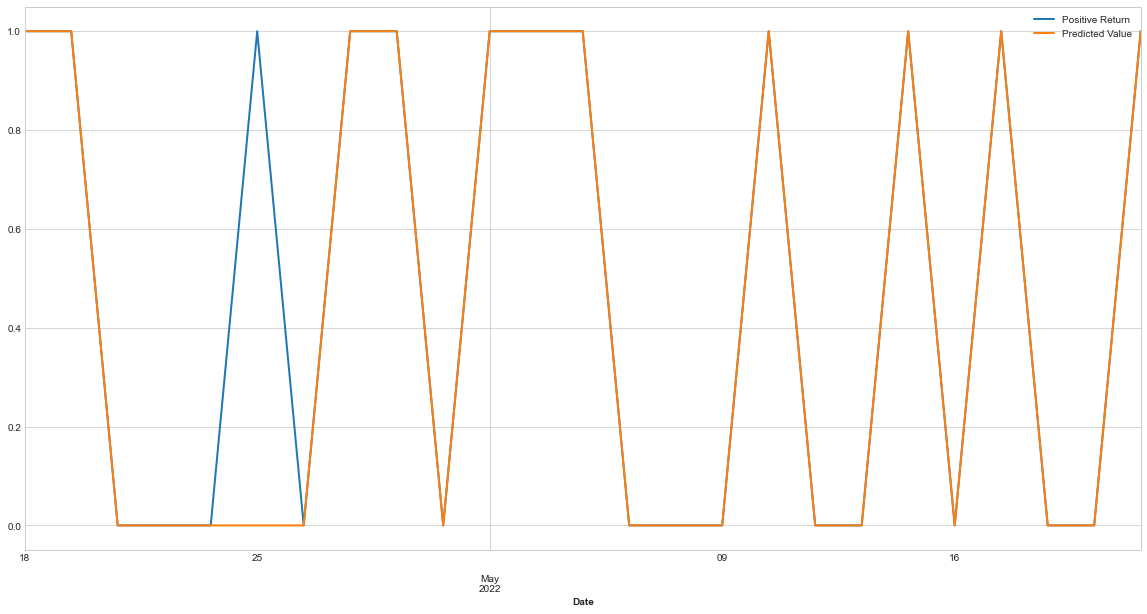

In [56]:
# Plot predicted results vs. actual results
results[["Positive Return", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

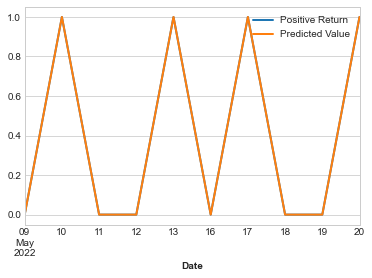

In [57]:
# Plot last 10 records of predicted vs. actual results
results[["Positive Return", "Predicted Value"]].tail(10).plot()

In [58]:
results['Return'] = df_stock['pct_change']
results

,Positive Return,Predicted Value,Return
Date,,,
2022-04-18,1.0,1.0,0.041114
2022-04-19,1.0,1.0,1.614267
2022-04-20,0.0,0.0,-0.074154
2022-04-21,0.0,0.0,-1.495355
2022-04-22,0.0,0.0,-2.743914
2022-04-25,1.0,0.0,0.579758
2022-04-26,0.0,0.0,-2.896083
2022-04-27,1.0,1.0,0.281178
2022-04-28,1.0,1.0,2.525945


<AxesSubplot:xlabel='Date'>

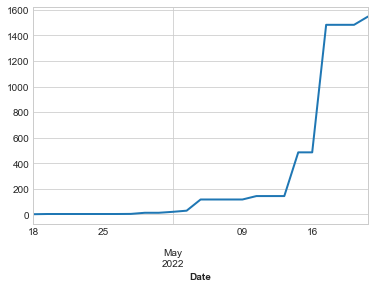

In [59]:
# Calculate cumulative return of the model
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Date'>

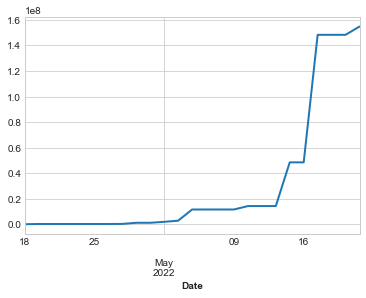

In [60]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()